In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciii_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286


| Step 1  ==> Calibrating model


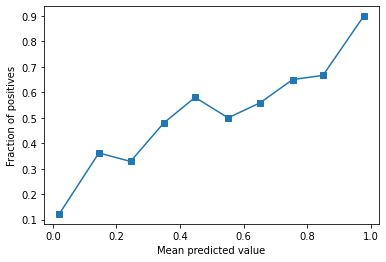

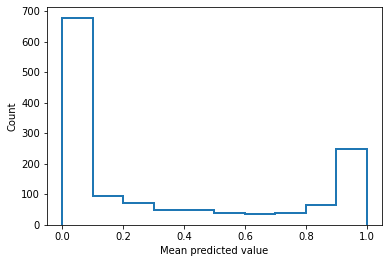

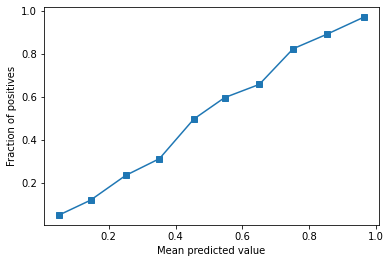

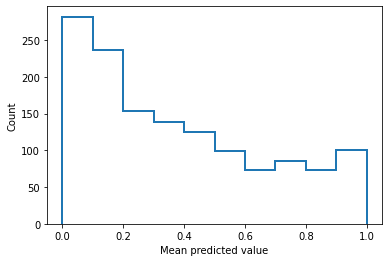

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286
ROC AUC: 0.8721534530098864
Average Precision: 0.8290653997048896
Accuracy: 0.7995610826627652

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 26.0

Probability threshold: 0.5
Score threshold: 42.0

Probability threshold: 0.9
Score threshold: 58.0



In [6]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [7]:
explainer.score_array_list

[array([11., -7.]),
 array([-4.,  5.]),
 array([-3.,  5.]),
 array([-3.,  4.]),
 array([-5.,  3.]),
 array([-3.,  1.]),
 array([ 1., -1.,  6.]),
 array([ 2., -1.]),
 array([-2.,  1.]),
 array([ 3., -1.])]

In [8]:
explainer.breakpoints_list

[[-0.3222222222222222, 8.410828101389876, 294.66041666666666],
 [11.6, 15.454288566314101, 30.5],
 [0.008, 5.248719849964527, 153.928],
 [18.258726899383984, 72.88063943601284, 90.0],
 [0.0, 0.9373030375089514, 3.0],
 [-8.271937992540188, 192.4997909660624, 23111.0],
 [0.0, 0.47620857694695967, 1.120348572471703, 5.0],
 [0.0, 2.741774085897918, 18.290282614674197],
 [0.2, 3.4469199152619843, 17.3],
 [-151.44629137482752, 157.25498164980556, 688.0]]

In [9]:
explainer.shap_array_list

[[1.5200895428088361, -0.9579244478824746],
 [-0.6099885462630585, 0.6927547991238919],
 [-0.45866317192439593, 0.7233876816519579],
 [-0.44808059866781996, 0.6111491107487586],
 [-0.6283311741860277, 0.4108899861692078],
 [-0.3970609397226353, 0.08446878562790393],
 [0.1211356264817674, -0.14107915549971353, 0.8303772067736443],
 [0.25014018746438604, -0.1936853626523933],
 [-0.22643629017454586, 0.20312588565406928],
 [0.4238853968868893, -0.1378857191974648]]

In [21]:
i = 0
import math
for variable in explainer.variables:
    shap_array = explainer.shap_array_list[i]
    breakpoints = explainer.breakpoints_list[i]
    min_shap_value = np.min(shap_array)
    
    j = 0
    for shap_value in shap_array:
        # if variable
        odds_ratio = math.exp(shap_value - min_shap_value)
        odds_ratio = round(odds_ratio, 3)
        if j == 0:
            upper_threshold = round(breakpoints[j+1], 2)
            print(variable + "<=" + str(upper_threshold))
        elif j+1 < len(shap_array):
            lower_threshold = round(breakpoints[j], 2)
            upper_threshold = round(breakpoints[j+1], 2)
            print(str(lower_threshold) + "<" 
                  + variable + "<=" 
                  + str(upper_threshold))
        else:
            lower_threshold = round(breakpoints[j], 2)
            print(str(lower_threshold) + "<" + variable)
        j+=1
        print("Odds Ratio: " + str(odds_ratio))
    
    print()
    i+=1

LOS<=8.41
Odds Ratio: 11.918
8.41<LOS
Odds Ratio: 1.0

RDW<=15.45
Odds Ratio: 1.0
15.45<RDW
Odds Ratio: 3.679

ICU_LOS<=5.25
Odds Ratio: 1.0
5.25<ICU_LOS
Odds Ratio: 3.261

Age<=72.88
Odds Ratio: 1.0
72.88<Age
Odds Ratio: 2.884

inotropes<=0.94
Odds Ratio: 1.0
0.94<inotropes
Odds Ratio: 2.827

Lactate Dehydrogenase (LD)<=192.5
Odds Ratio: 1.0
192.5<Lactate Dehydrogenase (LD)
Odds Ratio: 1.619

ICUs<=0.48
Odds Ratio: 1.3
0.48<ICUs<=1.12
Odds Ratio: 1.0
1.12<ICUs
Odds Ratio: 2.642

Albumin<=2.74
Odds Ratio: 1.559
2.74<Albumin
Odds Ratio: 1.0

Phosphate<=3.45
Odds Ratio: 1.0
3.45<Phosphate
Odds Ratio: 1.537

Haptoglobin<=157.25
Odds Ratio: 1.754
157.25<Haptoglobin
Odds Ratio: 1.0



In [10]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.7445696990566637
Average Precision: 0.6462152297850027
Accuracy: 0.6986100950987564
[[786  58]
 [354 169]]


In [25]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [30]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.7469063456868335, 0.7376555577417688, 0.7561571336318981)
(0.6471622941122264, 0.6342367766283696, 0.6600878115960831)
(0.6975999999999999, 0.6902457637156658, 0.704954236284334)


In [25]:
from scipy.special import expit

scoring_table_columns = ['Score', 'Probability']
reference_zero = True

neg_score_list = []
pos_score_list = []

for score_array in explainer.score_array_list:
    neg_score_list.append(np.min(score_array))
    pos_score_list.append(np.max(score_array))

min_score = np.sum(neg_score_list)
max_score = np.sum(pos_score_list)

scoring_table = pd.DataFrame(columns = scoring_table_columns)
score_thresholds = []

i = min_score
while i <= max_score:
    score = i
    if reference_zero == True:
        score += abs(min_score)

    prob = expit(i * explainer.unit_shap_value + explainer.expected_value)
    new_row = pd.DataFrame([[score, prob]],columns=scoring_table_columns)
    scoring_table = pd.concat([scoring_table, new_row])

    i += 1

scoring_table = scoring_table.reset_index(drop=True)

# print("")
# print("")

# for p_threshold in self.p_thresholds:
#     print("Probability threshold: " + str(p_threshold))
#     score_threshold = self.scoring_table[self.scoring_table['Probability'] <= p_threshold]['Score'].max()
#     self.score_thresholds.append(score_threshold)
#     print("Score threshold: " + str(score_threshold))
#     print("")


In [27]:
min_score

-30.0

In [30]:
expit(explainer.expected_value)

0.15726059944028759

In [28]:
scoring_table[scoring_table['Score'] >= 30]

,Score,Probability
30,30.0,0.157261
31,31.0,0.176409
32,32.0,0.197343
33,33.0,0.220098
34,34.0,0.244676
35,35.0,0.271045
36,36.0,0.299131
37,37.0,0.328814
38,38.0,0.35993
39,39.0,0.39227


In [9]:
shap_values_df = pd.DataFrame(explainer.shap_values, columns=explainer.X_train.columns)

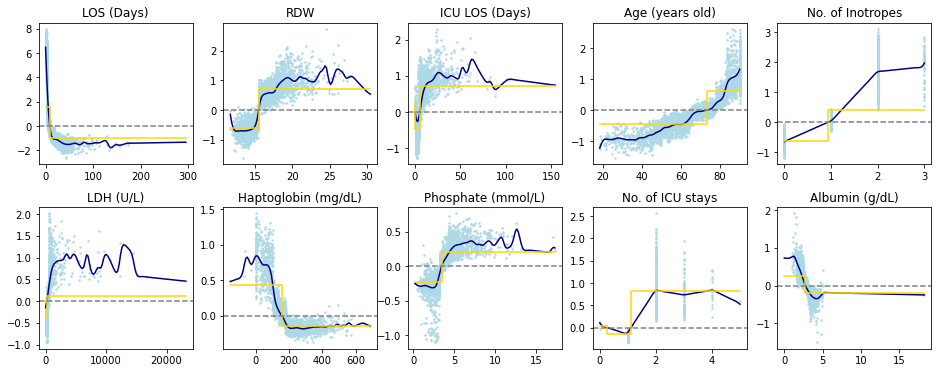

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

titles = ["LOS (Days)", "RDW", "ICU LOS (Days)", "Age (years old)", "No. of Inotropes",
         "LDH (U/L)", "Haptoglobin (mg/dL)", "Phosphate (mmol/L)", "No. of ICU stays", "Albumin (g/dL)"]
j = 0
for variable in explainer.variables:
    # print(variable)
    x = explainer.X_train[variable].values
    y = shap_values_df[variable].values

    y = y[np.argsort(x)]
    x = x[np.argsort(x)]

    score_x = []
    score_y = []
    
    i = 0
    #for score in explainer.score_array_list[j]:
    for score in explainer.shap_array_list[j]:
        score_x.append(explainer.breakpoints_list[j][i])
        score_y.append(score)
        score_x.append(explainer.breakpoints_list[j][i+1])
        score_y.append(score)
        i+=1
        
    xs = explainer.xs_array[j]
    ys = explainer.ys_array[j]

    #plt.subplots() 
    plt.subplot(2, 5, j+1)
    plt.scatter(x, y, s=2, c='lightblue')
    plt.plot(xs, ys, c='navy')
    plt.plot(score_x, score_y, c='gold')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(titles[j])
    j+=1

plt.subplots_adjust(hspace=0.3)
plt.show()

In [25]:
explainer.xs_array


[array([ -0.32222222,   2.65740039,   5.63702301,   8.61664562,
         11.59626824,  14.57589085,  17.55551347,  20.53513608,
         23.5147587 ,  26.49438131,  29.47400393,  32.45362654,
         35.43324916,  38.41287177,  41.39249439,  44.372117  ,
         47.35173962,  50.33136223,  53.31098485,  56.29060746,
         59.27023008,  62.24985269,  65.22947531,  68.20909792,
         71.18872054,  74.16834315,  77.14796577,  80.12758838,
         83.107211  ,  86.08683361,  89.06645623,  92.04607884,
         95.02570146,  98.00532407, 100.98494669, 103.9645693 ,
        106.94419192, 109.92381453, 112.90343715, 115.88305976,
        118.86268238, 121.84230499, 124.82192761, 127.80155022,
        130.78117284, 133.76079545, 136.74041807, 139.72004068,
        142.6996633 , 145.67928591, 148.65890853, 151.63853114,
        154.61815376, 157.59777637, 160.57739899, 163.5570216 ,
        166.53664422, 169.51626684, 172.49588945, 175.47551207,
        178.45513468, 181.4347573 , 184.

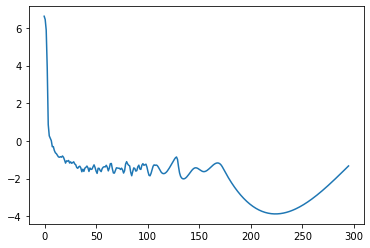

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from csaps import csaps

x = explainer.X_train['LOS'].values
y = shap_values_df['LOS'].values

y = y[np.argsort(x)]
x = x[np.argsort(x)]

x_unique = np.unique(x)
y_unique = []
for xi in x_unique:
    y_unique.append(np.mean(y[np.where(x==xi)]))
    
y_unique = np.array(y_unique)

spline_sample_size = 300
xs = np.linspace(x_unique[0], x_unique[-1], spline_sample_size)
smoothing_result = csaps(x_unique, y_unique, xs, smooth=0.8)
ys = smoothing_result

plt.plot(xs, ys)

# plt.scatter(explainer.X_train['LOS'], shap_values_df['LOS'])


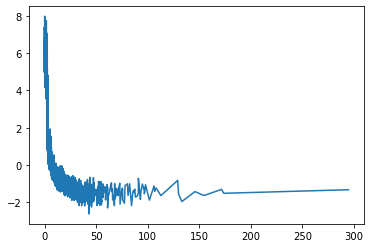

In [19]:
# from scipy import interpolate

# interpolate.interp2d(x_unique, y_unique, xs, kind='linear')
plt.plot(x_unique, y_unique)
plt.show()

In [152]:
ordered_variables = explainer.X_train.columns[np.argsort(np.abs(explainer.shap_values.mean(0)))][::-1]

In [159]:
# from sklearn.model_selection import cross_validation
from sklearn.model_selection import cross_validate

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed)

scores = []

for i in range(len(ordered_variables)):
    results = cross_validate(clf, X_train[ordered_variables[:i+1]], y_train, cv=5, scoring="roc_auc")
    scores.append(np.mean(results['test_score']))
    print(ordered_variables[:i+1])
    print(results["test_score"])
    print()
    

Index(['LOS'], dtype='object')
[0.64157067 0.58560192 0.61511695 0.63754577 0.60441992]

Index(['LOS', 'ICU_LOS'], dtype='object')
[0.7068881  0.73885503 0.70038548 0.7099592  0.69373365]

Index(['LOS', 'ICU_LOS', 'ICUs'], dtype='object')
[0.73183801 0.74913268 0.73531802 0.73436552 0.70642327]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron'], dtype='object')
[0.73787461 0.77298536 0.75513882 0.74258814 0.74787112]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate'], dtype='object')
[0.76378454 0.76840131 0.77121425 0.76843812 0.74524532]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess'], dtype='object')
[0.78767009 0.79438454 0.77305829 0.77456847 0.76365729]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW'], dtype='object')
[0.78682486 0.80985571 0.77759025 0.78487289 0.78947589]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12'],
      dtype='object')
[0.79906503 0.80282336 0.78130958 0.781023

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2'],
      dtype='object')
[0.83861341 0.82823358 0.83501589 0.828957   0.85453499]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', '

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes'],
      dtype='object')
[0.84354913 0.83019222 0.84801792 0.833152   0.85294487]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect'

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals'],
      dtype='object')
[0.85409884 0.83091108 0.83926655 0.83120619 0.84264044]

Index

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

KeyboardInterrupt: 

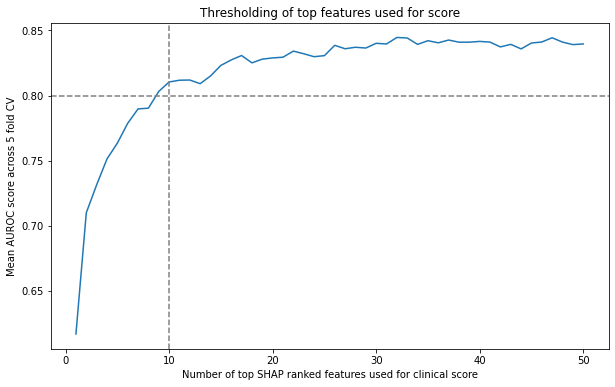

In [176]:
x = np.linspace(1, 50, 50)
plt.figure(figsize=(10, 6))
plt.plot(x, scores[:50])
plt.axhline(0.8, linestyle='--', color='gray')
plt.axvline(10, linestyle='--', color='gray')
plt.ylabel("Mean AUROC score across 5 fold CV")
plt.xlabel("Number of top SHAP ranked features used for clinical score")
plt.title("Thresholding of top features used for score")
plt.show()